# Finding Lane Lines on the Road

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


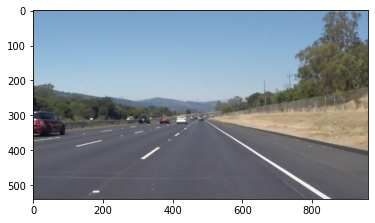

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

## Helper Functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # Anzahl der channels eines images, i.e. 3 depending on your image; 
                                      # wird bei der Abfrage "image.shape" mit angegeben >> z.B. (540, 960, 3)
        mask_color = (255,) * channel_count
    else:
        mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, mask_color) # aus Doku: cv2.fillPoly(img, pts, color)
                                             # pts --> "Array of polygons where each polygon is represented as an array of points"
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask) # dt. binäres UND
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    Diese Funktion verändert und überschreibt das ursprünliche Bild, welches per "img" an die Funktion übergeben wird.  
    
    img >> Das Bild das an die Funktion übergeben wird (i.d.R das leere mit "0ern" befüllte line_img). Dieses wird verändert,
            indem die Linien drüber gezeichnet werden.
    
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)    
    
    """
    
    # m = slope, b = intercept. Initialize 4 lists: left and right slope, left and right intercept
    lm = np.array(())
    lb = np.array(())
    rm = np.array(())
    rb = np.array(())
    
    # img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if (np.isfinite(slope)) and (abs(slope)<=1) and (abs(slope) >= .5):
                b = y1-slope*x1
                if slope < 0: 
                    lm = np.append(lm, slope)
                    lb = np.append(lb, b)
                else:
                    rm = np.append(rm, slope)
                    rb = np.append(rb,b)
                    
    # get average slopes and intercepts for left and right. Then find 2 points to draw one line in between.
    lm_average = np.average(lm)
    lb_average = np.average(lb)
    rm_average = np.average(rm)
    rb_average = np.average(rb)
    
    l_point1 = (int((img.shape[0] - lb_average)/lm_average), int(img.shape[0])) # x = (y-b)/m
    l_point2 = (int(((310)- lb_average)/lm_average), int(310))
    cv2.line(img, l_point1, l_point2, color, thickness)
    
    r_point1 = (int((img.shape[0] - rb_average)/rm_average), int(img.shape[0]))
    r_point2 = (int(((310)- rb_average)/rm_average), int(310))
    cv2.line(img, r_point1, r_point2, color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Hier nichts ändern! Entspricht dem Originalzustand.
    
    Durch diese Funktion erhält man ein Bild mit Linien.
    
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines) # hierdurch wird line_img nochmal verändert
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.): # ein aus 2 Bildern überlagertes Gesamtbild mit α, β und γ gewichtet
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

**We make sure our pipeline works well on these images before we try the videos.**

In [4]:
import os #This module provides a portable way of using operating system dependent functionality.
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Building the pipeline and running the solution on all test_images. We make copies into the `test_images_output` directory, so we can use the images late in the documentation.

We tune the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

True

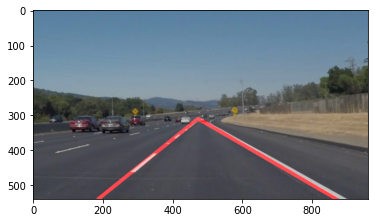

In [5]:
# Build pipeline that will draw lane lines on the test_images. Then save them to the test_images_output directory.

# reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

# grayscale image
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# blur the image with Gaussian Blur to enhance the result
# select a kernel size (second parameter). Must be an odd number (3, 5, 7...).
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
blur_gray = gaussian_blur(gray, 3)

# Define the parameters for Canny and apply
low_threshold = 80
high_threshold = 220
edges = canny(blur_gray, low_threshold, high_threshold)

# Select a region of interest
# the origin (x=0, y=0) is in the upper left
left_bottom = np.array([0, 539])
right_bottom = np.array([900, 539])
apex = np.array([500, 310])
vertices = np.array([left_bottom, right_bottom, apex])
masked_edges = region_of_interest(edges, [vertices]) # vertices ist in square brackets, weil 
                                                       # es (s. helper functions oben) übergeben wird an 
                                                       # cv2.fillPoly(img, pts, color) als pts und pts als array von polygons (arrays) an points definiert ist. 
                                                       # Die points selbst sind zu allem Überfluss auch arrays.
                                                       # pts = [[[0 539][900 539][475 320]]]

# Define the Hough transform parameters and apply
rho = 1 # units of pixels
theta = np.pi/180 # units of radians
threshold = 3 # minimum number of intersections a candidate line needs to have to make it into the output
min_line_len = 5 # minimum length of a line (in pixels) that you will accept in the output
max_line_gap = 3 # maximum distance (in pixels) between segments that you will allow to be connected into a single line

line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap) # a blank image (all black) with lines drawn on it.

# combine the line_image with the initial image
# The result image is computed as follows: initial_img * α + img * β + γ; NOTE: initial_img and img must be the same shape!
combo = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

plt.imshow(combo)

# save processed image into the test_images_output directory
cv2.imwrite("examples/combo.jpg", combo)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The returned output should be a color image (3 channels) for processing videos below
    
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 3) # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally

    #canny
    low_threshold = 80
    high_threshold = 220
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Select a region of interest
    # the origin (x=0, y=0) is in the upper left
    left_bottom = np.array([0, 539])
    right_bottom = np.array([900, 539])
    apex = np.array([500, 310])
    vertices = np.array([left_bottom, right_bottom, apex])
    masked_edges = region_of_interest(edges, [vertices])
    
    # Define the Hough transform parameters and apply
    rho = 1 # units of pixels
    theta = np.pi/180 # units of radians
    threshold = 3 # minimum number of intersections a candidate line needs to have to make it into the output
    min_line_len = 5 # minimum length of a line (in pixels) that you will accept in the output
    max_line_gap = 3 # maximum distance (in pixels) between segments that you will allow to be connected into a single line
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap) # a blank image (all black) with lines drawn on it.

    # combine the line_image with the initial image
    # The result image is computed as follows: initial_img * α + img * β + γ; NOTE: initial_img and img must be the same shape!
    combo = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

    return combo

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so .subclip(start_second,end_second) was added
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|                                                                             | 0/125 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 6.09 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so .subclip(start_second,end_second) was added
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|                                                                             | 0/125 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 6.28 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))